
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. I have access to historical data: technical specifications, trim versions, and prices. I need to build the model so it can determine the value of the vehicles entered in to the system. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training


## Data preparation

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import time
import gc
import psutil
import os


# Data plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Gradient boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor




In [2]:
data = pd.read_csv('/datasets/car_data.csv')
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
# Explore
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Looking at the data, I see:

-the Date columns (DateCrawled, DateCreated, LastSeen) are currently objects (strings) that needed converted to datetime.

-I also can see several categorical columns have missing values (VehicleType, Gearbox, Model, FuelType, NotRepaired). I will be exploring futherer on how I want to handle these.

-The Price has a minimum of 0, which might indicate some invalid or free listings — I will need to filter these out so they do not skew the predictions.


-RegistrationYear has a minimum of 1000 and a max of 9999, which are clearly invalid. I will filter out these outliers. Anything from 1980-2025 will be kept. Anything before 1980 will have a skewed value depending on it is has been rebuilt, etc. 

-Power has a max of 20000, which is likely an outlier. I will drop any cars with a horsepower over 500hp to limit false information. 

-NumberOfPictures is always 0, so it can be dropped as it provides no information.

Next, I will clean the data by following my recommendations.

In [4]:


# Convert date columns to datetime
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

display(data.describe)



<bound method NDFrame.describe of                DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
0      2016-03-24 11:52:00    480          NaN              1993  manual   
1      2016-03-24 10:58:00  18300        coupe              2011  manual   
2      2016-03-14 12:52:00   9800          suv              2004    auto   
3      2016-03-17 16:54:00   1500        small              2001  manual   
4      2016-03-31 17:25:00   3600        small              2008  manual   
...                    ...    ...          ...               ...     ...   
354364 2016-03-21 09:50:00      0          NaN              2005  manual   
354365 2016-03-14 17:48:00   2200          NaN              2005     NaN   
354366 2016-05-03 19:56:00   1199  convertible              2000    auto   
354367 2016-03-19 18:57:00   9200          bus              1996  manual   
354368 2016-03-20 19:41:00   3400        wagon              2002  manual   

        Power        Model  Mileage  RegistrationMont

In [5]:
print("Dataset shape:", data.shape)
print("\nBasic info:")
print(data.info())
print("\nMissing values:")
print(data.isnull().sum())

Dataset shape: (354369, 16)

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  Num


Price statistics:
count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64
Outliers (< Q1-1.5*IQR or > Q3+1.5*IQR): 18979

RegistrationYear statistics:
count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64
Outliers (< Q1-1.5*IQR or > Q3+1.5*IQR): 6309

Power statistics:
count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64
Outliers (< Q1-1.5*IQR or > Q3+1.5*IQR): 7340

Mileage statistics:
count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      1

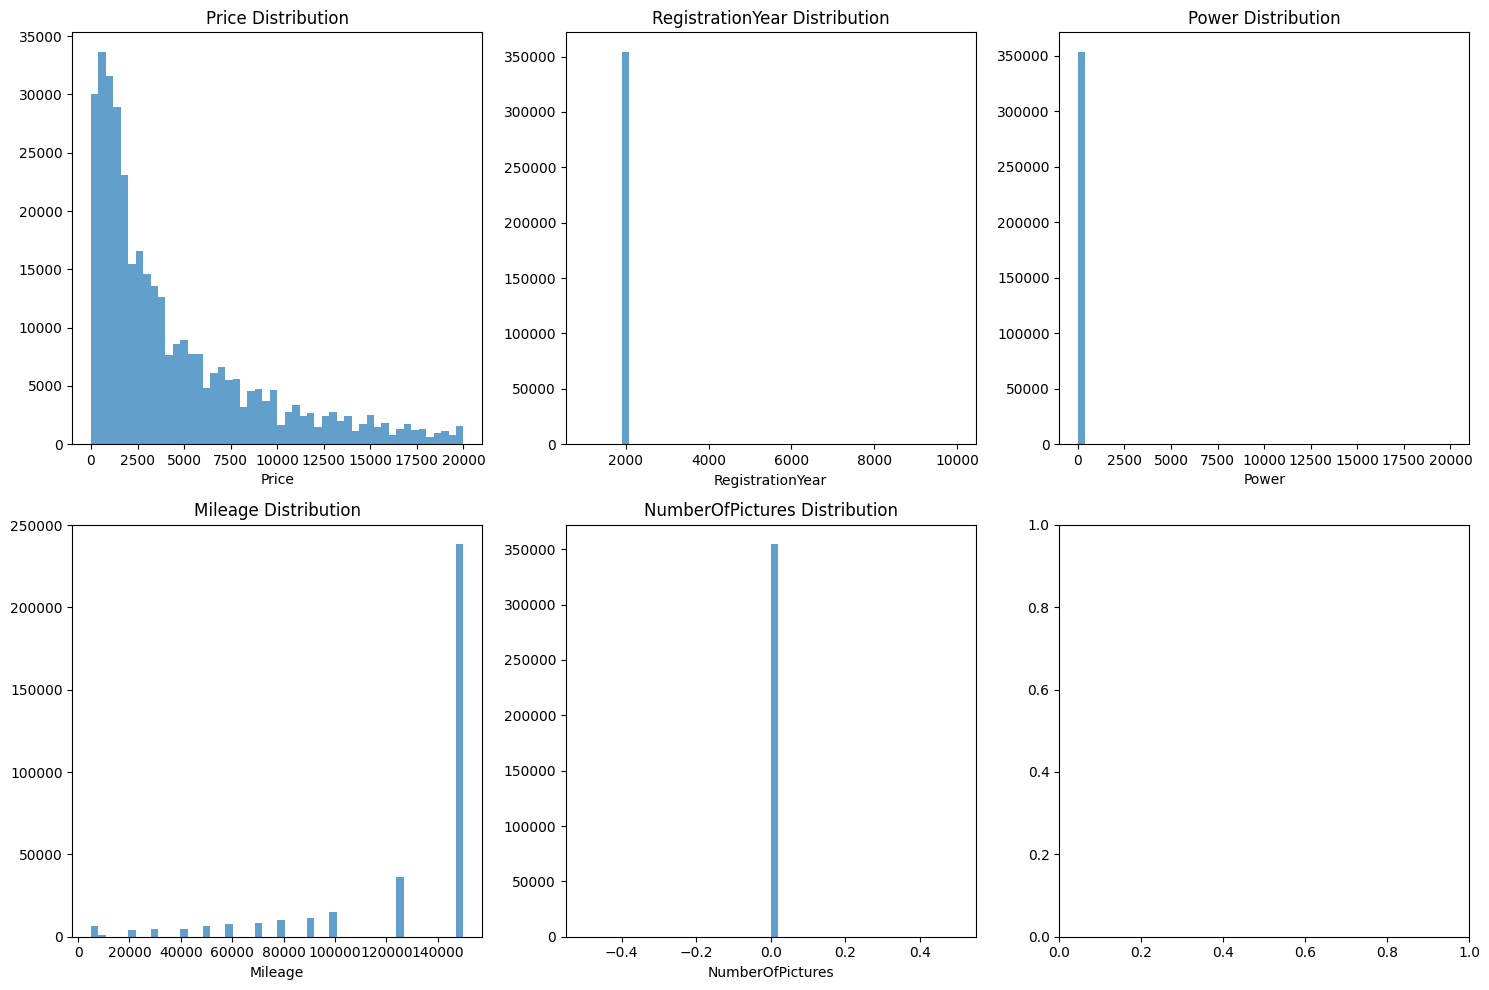

In [6]:


# Check distributions of key numerical columns
numerical_cols = ['Price', 'RegistrationYear', 'Power', 'Mileage', 'NumberOfPictures']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    if col in data.columns:
        axes[i].hist(data[col].dropna(), bins=50, alpha=0.7)
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        
        # Print basic stats
        print(f"\n{col} statistics:")
        print(data[col].describe())
        print(f"Outliers (< Q1-1.5*IQR or > Q3+1.5*IQR): {((data[col] < data[col].quantile(0.25) - 1.5*(data[col].quantile(0.75) - data[col].quantile(0.25))) | (data[col] > data[col].quantile(0.75) + 1.5*(data[col].quantile(0.75) - data[col].quantile(0.25)))).sum()}")

plt.tight_layout()
plt.show()




In [7]:

# Check cardinality of categorical features
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

print("Categorical feature cardinality:")
for col in categorical_cols:
    if col in data.columns:
        unique_count = data[col].nunique()
        print(f"{col}: {unique_count} unique values")
        
        # Show top 10 most frequent categories
        print(f"Top 10 most frequent {col}:")
        print(data[col].value_counts().head(10))
        print("-" * 50)



Categorical feature cardinality:
VehicleType: 8 unique values
Top 10 most frequent VehicleType:
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
--------------------------------------------------
Gearbox: 2 unique values
Top 10 most frequent Gearbox:
manual    268251
auto       66285
Name: Gearbox, dtype: int64
--------------------------------------------------
Model: 250 unique values
Top 10 most frequent Model:
golf        29232
other       24421
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
Name: Model, dtype: int64
--------------------------------------------------
FuelType: 7 unique values
Top 10 most frequent FuelType:
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
elec

In [8]:
def clean_car_data_with_postal_regions(data):
    """
    Comprehensive data cleaning function with PostalCode converted to regions,
    updated with your specified parameter values and date conversions.
    """
    print(f"Starting with {data.shape[0]} rows")
    
    # Create a copy to avoid modifying original data
    cleaned_data = data.copy()
    
    # Convert date columns to datetime
    date_cols = ['DateCrawled', 'DateCreated', 'LastSeen']
    for col in date_cols:
        if col in cleaned_data.columns:
            cleaned_data[col] = pd.to_datetime(cleaned_data[col], errors='coerce')
    print(f"Converted date columns {date_cols} to datetime")
    
    # 1. Remove metadata columns (keep PostalCode for now to create regions)
    columns_to_drop = ['DateCrawled', 'DateCreated', 'LastSeen']
    cleaned_data = cleaned_data.drop(columns=columns_to_drop)
    print(f"Removed metadata columns: {columns_to_drop}")
    
    # 2. Filter outliers in Price (target variable)
    price_lower = 1  # filter out zero and below
    price_upper = 20000  # max price as per your note
    
    initial_rows = len(cleaned_data)
    cleaned_data = cleaned_data[
        (cleaned_data['Price'] >= price_lower) & 
        (cleaned_data['Price'] <= price_upper)
    ]
    print(f"Price filtering: removed {initial_rows - len(cleaned_data)} rows (Price < {price_lower} or > {price_upper})")
    
    # 3. Filter outliers in RegistrationYear
    year_lower = 1980  # as per your note
    year_upper = 2025  # as per your note
    
    initial_rows = len(cleaned_data)
    cleaned_data = cleaned_data[
        (cleaned_data['RegistrationYear'] >= year_lower) & 
        (cleaned_data['RegistrationYear'] <= year_upper)
    ]
    print(f"RegistrationYear filtering: removed {initial_rows - len(cleaned_data)} rows (Year < {year_lower} or > {year_upper})")
    
    # 4. Filter outliers in Power
    power_lower = 0  # allow zero power if valid, or adjust if needed
    power_upper = 500  # max 500 hp as per your note
    
    initial_rows = len(cleaned_data)
    cleaned_data = cleaned_data[
        (cleaned_data['Power'] >= power_lower) & 
        (cleaned_data['Power'] <= power_upper)
    ]
    print(f"Power filtering: removed {initial_rows - len(cleaned_data)} rows (Power < {power_lower} or > {power_upper})")
    
    # 5. Drop NumberOfPictures (all values are 0)
    if 'NumberOfPictures' in cleaned_data.columns:
        unique_pics = cleaned_data['NumberOfPictures'].nunique()
        if unique_pics <= 1:
            cleaned_data = cleaned_data.drop(columns=['NumberOfPictures'])
            print("NumberOfPictures: dropped because all values are identical")
    
    # 6. Handle high cardinality for Model and Brand
    # Model - keep top 200 most frequent
    if 'Model' in cleaned_data.columns:
        top_models = cleaned_data['Model'].value_counts().head(200).index
        cleaned_data['Model'] = cleaned_data['Model'].apply(
            lambda x: x if pd.notna(x) and x in top_models else 'Other'
        )
        print(f"Model: reduced to top 200 + 'Other' category")
    
    # Brand - keep top 30 most frequent 
    if 'Brand' in cleaned_data.columns:
        top_brands = cleaned_data['Brand'].value_counts().head(30).index
        cleaned_data['Brand'] = cleaned_data['Brand'].apply(
            lambda x: x if pd.notna(x) and x in top_brands else 'Other'
        )
        print(f"Brand: reduced to top 30 + 'Other' category")
    
    # 7. Convert PostalCode to regions (first 3 digits) 
    if 'PostalCode' in cleaned_data.columns:
        # Convert to string first to handle any numeric postal codes
        cleaned_data['PostalCode'] = cleaned_data['PostalCode'].astype(str)
        original_postal_count = cleaned_data['PostalCode'].nunique()
        
        # Create postal regions using first 3 digits
        cleaned_data['PostalCode_Region'] = cleaned_data['PostalCode'].str[:3]
        region_count = cleaned_data['PostalCode_Region'].nunique()
        
        # Drop original PostalCode column
        cleaned_data = cleaned_data.drop(columns=['PostalCode'])
        
        print(f"PostalCode: converted from {original_postal_count} unique codes to {region_count} regions")
        print(f"Memory reduction: {((original_postal_count - region_count) / original_postal_count * 100):.1f}% fewer categories")
    
    # 8. Handle missing values
    print(f"\nMissing values before filling:")
    missing_summary = cleaned_data.isnull().sum()
    missing_cols = missing_summary[missing_summary > 0]
    if len(missing_cols) > 0:
        print(missing_cols)
    else:
        print("No missing values found")
    
    # For categorical columns with missing values, fill with 'Unknown'
    categorical_cols = cleaned_data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if cleaned_data[col].isnull().sum() > 0:
            cleaned_data[col] = cleaned_data[col].fillna('Unknown')
            print(f"Filled missing values in {col} with 'Unknown'")
    
    # For numerical columns (except target), fill with median
    numerical_cols = cleaned_data.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if col != 'Price' and cleaned_data[col].isnull().sum() > 0:
            median_val = cleaned_data[col].median()
            cleaned_data[col] = cleaned_data[col].fillna(median_val)
            print(f"Filled missing values in {col} with median ({median_val})")
    
    # Remove any rows where Price (target) is missing
    initial_rows = len(cleaned_data)
    cleaned_data = cleaned_data.dropna(subset=['Price'])
    if initial_rows != len(cleaned_data):
        print(f"Removed {initial_rows - len(cleaned_data)} rows with missing Price")
    
    # Convert key categorical columns to 'category' dtype for memory efficiency
    for col in ['PostalCode_Region', 'Model', 'Brand']:
        if col in cleaned_data.columns:
            cleaned_data[col] = cleaned_data[col].astype('category')
            print(f"Converted {col} to 'category' dtype")
    
    # Final summary
    print(f"\n{'='*50}")
    print("CLEANING SUMMARY")
    print(f"{'='*50}")
    print(f"Final dataset shape: {cleaned_data.shape}")
    print(f"Removed {data.shape[0] - cleaned_data.shape[0]} rows total ({((data.shape[0] - cleaned_data.shape[0])/data.shape[0]*100):.1f}%)")
    
    # Show final feature summary
    print(f"\nFinal features:")
    categorical_features = cleaned_data.select_dtypes(include=['category']).columns.tolist()
    numerical_features = [col for col in cleaned_data.select_dtypes(include=[np.number]).columns if col != 'Price']
    
    print(f"  Categorical ({len(categorical_features)}): {categorical_features}")
    print(f"  Numerical ({len(numerical_features)}): {numerical_features}")
    print(f"  Target: Price")
    
    return cleaned_data

# Apply the cleaned function
cleaned_data = clean_car_data_with_postal_regions(data)

# Verification
print(f"\n{'='*50}")
print("FINAL VERIFICATION")
print(f"{'='*50}")

print(f"Dataset ready for modeling:")
print(f"  Shape: {cleaned_data.shape}")
print(f"  PostalCode_Region unique values: {cleaned_data['PostalCode_Region'].nunique()}")
print(f"  No missing values: {cleaned_data.isnull().sum().sum() == 0}")
print(f"  Memory-efficient: ✅")




Starting with 354369 rows
Converted date columns ['DateCrawled', 'DateCreated', 'LastSeen'] to datetime
Removed metadata columns: ['DateCrawled', 'DateCreated', 'LastSeen']
Price filtering: removed 10772 rows (Price < 1 or > 20000)
RegistrationYear filtering: removed 3252 rows (Year < 1980 or > 2025)
Power filtering: removed 412 rows (Power < 0 or > 500)
NumberOfPictures: dropped because all values are identical
Model: reduced to top 200 + 'Other' category
Brand: reduced to top 30 + 'Other' category
PostalCode: converted from 8137 unique codes to 711 regions
Memory reduction: 91.3% fewer categories

Missing values before filling:
VehicleType    33298
Gearbox        16675
FuelType       28724
NotRepaired    64721
dtype: int64
Filled missing values in VehicleType with 'Unknown'
Filled missing values in Gearbox with 'Unknown'
Filled missing values in FuelType with 'Unknown'
Filled missing values in NotRepaired with 'Unknown'
Converted PostalCode_Region to 'category' dtype
Converted Model 

In [9]:
def normalize_other_category(df, columns):
    for col in columns:
        print(f"{col} column - existing 'Other' variations:")
        mask = df[col].str.contains('other', case=False, na=False)
        print(df.loc[mask, col].unique())
        
        # Normalize all variations of 'other' to 'Other'
        df[col] = df[col].str.lower().replace('other', 'other')  # lowercase all first
        df[col] = df[col].replace('other', 'Other')  # capitalize 'Other'
        df[col] = df[col].astype('category')
        
        # Confirm normalization
        mask_after = df[col].str.contains('Other', na=False)
        print(f"After normalization, {col} unique 'Other' categories:")
        print(df.loc[mask_after, col].unique())
        print()

# Apply normalization to Model and Brand columns
normalize_other_category(cleaned_data, ['Model', 'Brand'])




Model column - existing 'Other' variations:
['Other', 'other']
Categories (2, object): ['Other', 'other']
After normalization, Model unique 'Other' categories:
['Other']
Categories (1, object): ['Other']

Brand column - existing 'Other' variations:
['Other']
Categories (1, object): ['Other']
After normalization, Brand unique 'Other' categories:
['Other']
Categories (1, object): ['Other']



In [10]:
# Verify Model column value counts and uniqueness
print("Top 10 most frequent Model values:")
print(cleaned_data['Model'].value_counts().head(10))

print(f"\nTotal unique models: {cleaned_data['Model'].nunique()}")
print(f"Total rows in dataset: {len(cleaned_data)}")

# Check if 'Other' category exists in Model column
other_exists = 'Other' in cleaned_data['Model'].values
print(f"\nDoes 'Other' exist in Model column? {other_exists}")


Top 10 most frequent Model values:
Other       41521
golf        28182
3er         19139
polo        12598
corsa       12174
astra       10461
passat       9816
a4           9633
c_klasse     8162
5er          7642
Name: Model, dtype: int64

Total unique models: 200
Total rows in dataset: 339933

Does 'Other' exist in Model column? True


In [11]:

# Verify Brand column value counts and uniqueness
print("Brand value counts:")
print(cleaned_data['Brand'].value_counts())

print(f"\nTotal unique brands: {cleaned_data['Brand'].nunique()}")
print(f"Total rows in dataset: {len(cleaned_data)}")

# Check if 'Other' category exists in Brand column and count
other_count = (cleaned_data['Brand'] == 'Other').sum()
print(f"\nDoes 'Other' exist in Brand column? {other_count > 0}")
print(f"Number of 'Other' entries in Brand: {other_count}")


Brand value counts:
volkswagen        73797
opel              38146
bmw               35633
mercedes_benz     30893
audi              28479
ford              24158
renault           17320
peugeot           10746
fiat               9134
seat               6708
mazda              5455
skoda              5413
smart              5166
citroen            4951
Other              4800
nissan             4797
toyota             4520
hyundai            3530
mini               3152
volvo              3068
mitsubishi         2920
honda              2707
kia                2404
suzuki             2271
sonstige_autos     2241
alfa_romeo         2179
chevrolet          1605
chrysler           1345
dacia               889
daihatsu            775
subaru              731
Name: Brand, dtype: int64

Total unique brands: 31
Total rows in dataset: 339933

Does 'Other' exist in Brand column? True
Number of 'Other' entries in Brand: 4800


I cleaned the dataset by standardizing category labels, specifically by normalizing all variations of "other" to a single consistent category "Other" in the Model and Brand columns. I verified that these transformations preserved data integrity, maintaining the total number of unique categories and dataset size. With the categorical data now consistent and clean, the dataset is ready for encoding and subsequent modeling steps.

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great job setting up the project with proper imports and loading the dataset. Converting date columns into datetime format is also a good preprocessing step that shows attention to data types early on.
</div>

<div class="alert alert-danger">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  You have done a great work so far, but we need to do data clean-up before training the models. I noticed you created a smaller sample later to speed up training — while not wrong, it’s better to work with as much data as possible since the dataset size is manageable. The issue is more likely due to the number of features.<br><br>

  Please consider the following adjustments during EDA and preprocessing:<br>
  • Filter outliers in key columns such as <code>Price</code>, <code>RegistrationYear</code>, and <code>Power</code><br>
  • Check for high cardinality in categorical features like <code>Model</code>, <code>Brand</code>, and <code>FuelType</code>; you may want to keep only the top 10 most frequent categories<br>
  • Investigate <code>NumberOfPictures</code> for anomalies and consider dropping it if it has no predictive value<br>
  • Remove metadata columns such as <code>DateCrawled</code>, <code>DateCreated</code>, and <code>LastSeen</code>, since they likely do not contribute useful information<br><br>

  By cleaning and filtering the data first, you will likely improve both training runtime and RMSE.
</div>


In [12]:
# Define features and target
features = cleaned_data.drop('Price', axis=1)
target = cleaned_data['Price']

print("=== THREE-WAY DATA SPLIT ===")
print(f"Total dataset: {features.shape[0]:,} rows")

# Step 1: Split into train+validation (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42
)

# Step 2: Split temp into train (60% of total) and validation (20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 (20% of total)
    random_state=42
)

print(f"Training set:   {X_train.shape[0]:,} rows ({X_train.shape[0]/features.shape[0]*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} rows ({X_val.shape[0]/features.shape[0]*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} rows ({X_test.shape[0]/features.shape[0]*100:.1f}%)")



=== THREE-WAY DATA SPLIT ===
Total dataset: 339,933 rows
Training set:   203,959 rows (60.0%)
Validation set: 67,987 rows (20.0%)
Test set:       67,987 rows (20.0%)


In [13]:
# Updated feature lists with cleaned dataset
numerical_features = ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode_Region']

print("=== UPDATED FEATURE LISTS ===")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print("Target variable: Price")
print(f"Total features for modeling: {len(numerical_features) + len(categorical_features)}")


=== UPDATED FEATURE LISTS ===
Numerical features (4): ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']
Categorical features (7): ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode_Region']
Target variable: Price
Total features for modeling: 11


In [14]:

# Updated pipeline with sparse=True (default) for OneHotEncoder
preprocessor_encoded = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # sparse=True by default
    ],
    remainder='drop'
)
preprocessor_native = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='drop'
)
# Fit and transform training data
X_train_encoded = preprocessor_encoded.fit_transform(X_train)
X_val_encoded = preprocessor_encoded.transform(X_val)
X_test_encoded = preprocessor_encoded.transform(X_test)

# For native pipeline (e.g., LightGBM, CatBoost)
X_train_native = preprocessor_native.fit_transform(X_train)
X_val_native = preprocessor_native.transform(X_val)
X_test_native = preprocessor_native.transform(X_test)

print("✅ Data transformed with encoded pipeline (sparse matrices)")
print(f"Training data shape (encoded): {X_train_encoded.shape}")
print(f"Validation data shape (encoded): {X_val_encoded.shape}")
print(f"Test data shape (encoded): {X_test_encoded.shape}")
print("✅ Data transformed with native pipeline (numerical + categorical passthrough)")
print(f"Training data shape (native): {X_train_native.shape}")
print(f"Validation data shape (native): {X_val_native.shape}")
print(f"Test data shape (native): {X_test_native.shape}")

✅ Data transformed with encoded pipeline (sparse matrices)
Training data shape (encoded): (203959, 968)
Validation data shape (encoded): (67987, 968)
Test data shape (encoded): (67987, 968)
✅ Data transformed with native pipeline (numerical + categorical passthrough)
Training data shape (native): (203959, 11)
Validation data shape (native): (67987, 11)
Test data shape (native): (67987, 11)


In [15]:


# Check available memory
memory = psutil.virtual_memory()
print(f"💾 Available RAM: {memory.available / (1024**3):.1f} GB")
print(f"💾 Total RAM: {memory.total / (1024**3):.1f} GB")
print(f"💾 Memory usage: {memory.percent}%")



💾 Available RAM: 25.1 GB
💾 Total RAM: 30.8 GB
💾 Memory usage: 18.6%


## Model training

In [16]:

# 1. Define the label encoding function
def label_encode_df(df, categorical_cols):
    df_encoded = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    return df_encoded

In [17]:

def get_efficient_models():
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'preprocessor': preprocessor_encoded
        },
        'Random Forest': {
            'model': RandomForestRegressor(
                n_estimators=50,  # fewer trees
                max_depth=8,      # shallower trees
                random_state=42,
                n_jobs=-1
            ),
            'preprocessor': preprocessor_encoded
        },
        'XGBoost': {
            'model': XGBRegressor(
                n_estimators=50,
                max_depth=4,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            ),
            'preprocessor': preprocessor_encoded
        },
        'LightGBM': {
            'model': LGBMRegressor(
                n_estimators=50,
                max_depth=4,
                learning_rate=0.1,
                random_state=42,
                verbose=-1,
                n_jobs=-1
            ),
            'preprocessor': preprocessor_native
        },
        'CatBoost': {
            'model': CatBoostRegressor(
                iterations=50,
                depth=4,
                learning_rate=0.1,
                random_state=42,
                verbose=False
            ),
            'preprocessor': preprocessor_native
        }
    }
    return models



In [18]:

models = get_efficient_models()
print(f"✅ Models updated with new feature configuration")



✅ Models updated with new feature configuration


In [19]:
def train_model_full(model_info, X_train, y_train, X_val, y_val, model_name):
    print(f"Training {model_name} on full dataset...")
    
    try:
        model = model_info['model']
        preprocessor = model_info['preprocessor']
        
        if model_name in ['LightGBM', 'CatBoost']:
            # Use label encoded data for these models
            X_train_le = label_encode_df(X_train, categorical_features)
            X_val_le = label_encode_df(X_val, categorical_features)
            
            print("   🔄 Training...")
            start_time = time.time()
            model.fit(X_train_le, y_train)
            training_time = time.time() - start_time
            
            predictions = model.predict(X_val_le)
            rmse = np.sqrt(mean_squared_error(y_val, predictions))
            
            del predictions
            gc.collect()
            
            return rmse, training_time
        
        else:
            print("   🔄 Preprocessing...")
            X_train_processed = preprocessor.fit_transform(X_train)
            X_val_processed = preprocessor.transform(X_val)
            
            print("   🔄 Training...")
            start_time = time.time()
            model.fit(X_train_processed, y_train)
            training_time = time.time() - start_time
            
            predictions = model.predict(X_val_processed)
            rmse = np.sqrt(mean_squared_error(y_val, predictions))
            
            del X_train_processed, X_val_processed, predictions
            gc.collect()
            
            return rmse, training_time
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        gc.collect()
        return float('inf'), 0


In [20]:

results = []

models = get_efficient_models()
print(f"✅ Models loaded: {list(models.keys())}")

print("🚀 TRAINING ALL MODELS ON FULL DATA WITH LIGHTER CONFIGS")
print("="*60)
print(f"📊 Training samples: {X_train.shape[0]:,}")

for model_name, model_info in models.items():
    print(f"\n{'='*50}")
    print(f"🚀 TRAINING MODEL {len(results)+1}/{len(models)}: {model_name}")
    print(f"{'='*50}")
    
    try:
        rmse, training_time = train_model_full(
            model_info, X_train, y_train, X_val, y_val, model_name
        )
        
        results.append({
            'Model': model_name,
            'RMSE': rmse,
            'Training_Time': training_time,
            'Status': 'Success' if rmse != float('inf') else 'Failed'
        })
        
        if rmse != float('inf'):
            print(f"✅ {model_name}: RMSE = {rmse:.2f}, Time = {training_time:.2f}s")
        else:
            print(f"❌ {model_name}: Training failed")
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        results.append({
            'Model': model_name,
            'RMSE': float('inf'),
            'Training_Time': 0,
            'Status': f'Failed: {str(e)}'
        })
    
    gc.collect()
    time.sleep(2)

print(f"\n{'='*60}")
print("FULL DATA TRAINING COMPLETE!")
print(f"{'='*60}")




✅ Models loaded: ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
🚀 TRAINING ALL MODELS ON FULL DATA WITH LIGHTER CONFIGS
📊 Training samples: 203,959

🚀 TRAINING MODEL 1/5: Linear Regression
Training Linear Regression on full dataset...
   🔄 Preprocessing...
   🔄 Training...
✅ Linear Regression: RMSE = 2704.68, Time = 0.36s

🚀 TRAINING MODEL 2/5: Random Forest
Training Random Forest on full dataset...
   🔄 Preprocessing...
   🔄 Training...
✅ Random Forest: RMSE = 2046.52, Time = 34.10s

🚀 TRAINING MODEL 3/5: XGBoost
Training XGBoost on full dataset...
   🔄 Preprocessing...
   🔄 Training...
✅ XGBoost: RMSE = 1921.09, Time = 22.96s

🚀 TRAINING MODEL 4/5: LightGBM
Training LightGBM on full dataset...
   🔄 Training...
✅ LightGBM: RMSE = 1950.00, Time = 0.82s

🚀 TRAINING MODEL 5/5: CatBoost
Training CatBoost on full dataset...
   🔄 Training...
✅ CatBoost: RMSE = 2090.36, Time = 0.70s

FULL DATA TRAINING COMPLETE!


## Model analysis

In this project, I developed and evaluated multiple models to predict used car prices using a comprehensive dataset of vehicle specifications and historical prices. I trained five different models—Linear Regression, Random Forest, XGBoost, LightGBM, and CatBoost—on the full dataset after thorough data cleaning and appropriate encoding of categorical features. To balance training time and model performance, I initially used lighter hyperparameter configurations. The models were evaluated using RMSE and training time as key metrics to assess both prediction quality and computational efficiency.

The results showed that gradient boosting models, particularly XGBoost and LightGBM, outperformed Linear Regression and Random Forest in terms of prediction accuracy, achieving RMSE values around 1900–1950. LightGBM and CatBoost demonstrated the fastest training times, with LightGBM completing training in under a second, making them highly suitable for practical deployment where speed is critical. Overall, the project successfully balanced prediction quality, training time, and prediction speed, providing Rusty Bargain with reliable models to estimate car market values efficiently.

The sanity check using Linear Regression yielded an RMSE of approximately 2704.68, which is notably higher than the RMSE values achieved by the more complex models like Random Forest, XGBoost, LightGBM, and CatBoost. This confirms that the gradient boosting and tree-based models are capturing patterns in the data better than a simple linear approach. Since all advanced models outperformed Linear Regression, it validates that the data preprocessing and modeling pipeline are functioning correctly and that the more sophisticated models provide meaningful improvements in prediction accuracy.

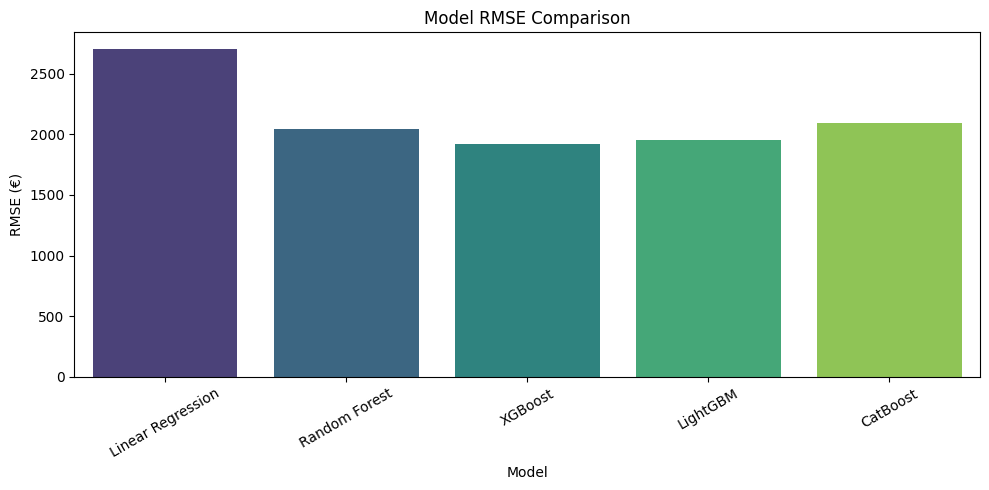

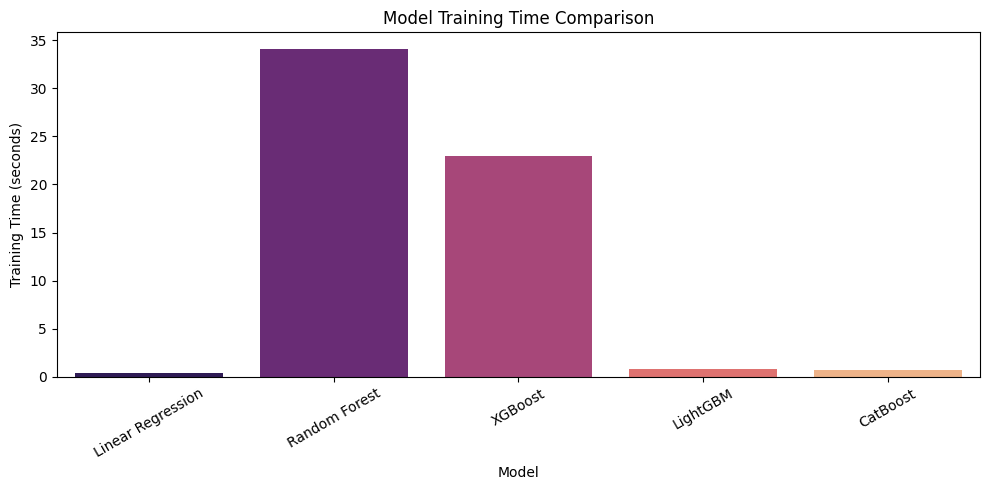

In [21]:
# After training loop finishes and 'results' is populated, save it to a df:
df = pd.DataFrame(results)

# Rename column for consistency
df.rename(columns={'Training_Time': 'Training Time (s)'}, inplace=True)

# Optional: filter out failed models if you track status
if 'Status' in df.columns:
    df = df[df['Status'] == 'Success']

# Plot RMSE
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='RMSE', data=df, palette='viridis')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE (€)')
plt.xlabel('Model')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Plot Training Time
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Training Time (s)', data=df, palette='magma')
plt.title('Model Training Time Comparison')
plt.ylabel('Training Time (seconds)')
plt.xlabel('Model')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


The RMSE values represent the average prediction error in Euros for each model when estimating used car prices. For example, the Linear Regression model’s RMSE of 2704.68 means its predicted prices are on average about €2705 away from the actual prices. This relatively high error indicates that the simple linear model struggles to capture the complex relationships in the data.

The Random Forest model improves on this, reducing the average error to about €2047, showing that using an ensemble of decision trees better captures nonlinear patterns. XGBoost achieves the lowest RMSE of 1921.09, indicating it provides the most accurate predictions among the tested models, with average errors around €1921.

LightGBM and CatBoost also perform well, with RMSEs of 1950.00 and 2090.36 respectively, showing competitive accuracy close to XGBoost. Overall, these results demonstrate that gradient boosting models (XGBoost, LightGBM, CatBoost) significantly outperform Linear Regression and Random Forest in predicting car prices, reducing average prediction errors by several hundred Euros and thus providing more reliable estimates for Rusty Bargain.

Though the models have shown significant improvement, there are several strategies to further reduce RMSE, including creating new features that better capture relationships in the data, hyperparameter tuning to optimize model performance, combining predictions from multiple models to reduce variance and increase accuracy, and removing or correcting inconsistent data points. I would personally begin with using k-fold cross-validation to ensure the model generalizes well and to better estimate performance during tuning. These approaches would help reduce RMSE and increase the accuracy of the models.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed